<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W1D5/tutorials/W1D5-DimensionalityReduction/W1D5-Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 1, Day 5, Tutorial 2
# Dimensionality Reduction: Principal component analysis


---

In this notebook we'll learn how to perform PCA by projecting the data onto the eigenvectors of its covariance matrix. 

Steps:
 1. Calculate the eigenvectors of the sample covariance matrix.
 2. Perform PCA by projecting data onto the eigenvectors of the covariance matrix. 
 3. Plot the eigenvalues.

---

Video available at https://youtube.com/watch?v=Ze0uK1ipEn0


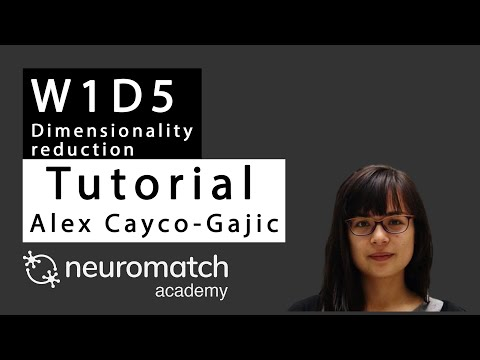

In [1]:
#@title Video: PCA
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Ze0uK1ipEn0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


# Setup
Run these cells to get the tutorial started.

In [2]:
#library imports
import time                        # import time 
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import math                        # import basic math functions
import random                      # import basic random number generator functions

import matplotlib.pyplot as plt    # import matplotlib
from IPython import display    

In [3]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 8)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

In [4]:
#@title Helper functions
# new helper functions
def plot_eigenvalues(evals):
  """
  Plots eigenvalues.
  
  Args:
     (numpy array of floats) : Vector of eigenvalues
     
  Returns: 
    Nothing.
    
  """
  plt.plot(np.arange(1,len(evals)+1),evals,'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  plt.xticks(np.arange(1,len(evals)+1))
  plt.ylim([0,2.5])

def sort_evals_descending(evals,evectors):
  """  
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats):   Vector of eigenvalues 
    evectors (numpy array of floats):   Corresponding matrix of eigenvectors 
                                each column corresponds to a different eigenvalue 
    
  Returns: 
    (numpy array of floats) : Vector of eigenvalues after sorting
    (numpy array of floats) : Matrix of eigenvectors after sorting
  """
  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:,index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:,0], 1./np.sqrt(2)*np.array([1,1]))) > np.pi/2.:
      evectors[:,0] = -evectors[:,0]
    if np.arccos(np.matmul(evectors[:,1], 1./np.sqrt(2)*np.array([-1,1]))) > np.pi/2.:
      evectors[:,1] = -evectors[:,1]
  return evals, evectors

  # Old helper functions from Tutorial 1

def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  scatter plot of their joint activity. The title indicates the sample correlation
  calculated from the data.

  Args:
    X (numpy array of floats):   Data matrix
                                  each column corresponds to a different random variable 
            
  Returns:
    Nothing.
  """
  fig = plt.figure(figsize=[8,4])
  gs = fig.add_gridspec(2,2)
  ax1 = fig.add_subplot(gs[0,0])
  ax1.plot(X[:,0],color='k')
  plt.ylabel('Neuron 1')
  ax2 = fig.add_subplot(gs[1,0])
  ax2.plot(X[:,1],color='k')
  plt.xlabel('Sample Number (sorted)')
  plt.ylabel('Neuron 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:,0],X[:,1],'.',markerfacecolor=[.5,.5,.5], markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:,0],X[:,1])[0,1]))

def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

  Note that samples are sorted in ascending order for the first random variable.

  Args:
    var_1 (scalar):    variance of the first random variable
    var_2 (scalar):    variance of the second random variable
    cov_matrix (numpy array of floats): desired covariance matrix
  
  Returns: 
    (numpy array of floats) : samples from the bivariate Gaussian, with
                              each column corresponding to a different random variable
  """
  mean = np.array([0,0])
  X = np.random.multivariate_normal(mean,cov_matrix,size = 1000)
  indices_for_sorting = np.argsort(X[:,0])
  X = X[indices_for_sorting,:]
  return X

def calculate_cov_matrix(var_1,var_2,corr_coef):
  """
  Calculates the covariance matrix based on the variances and correlation coefficient.
  
  Args:
    var_1 (scalar):    variance of the first random variable
    var_2 (scalar):    variance of the second random variable
    corr_coef (scalar):      correlation coefficient
  
  Returns: 
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1,cov],[cov,var_2]])
  return cov_matrix

def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.
  
  Args:
    u (numpy array of floats):    arbitrary 2D vector used for new basis
  
  Returns: 
    (numpy array of floats) : new orthonormal basis
                                columns correspond to basis vectors
  """
  u = u / np.sqrt(u[0]**2 + u[1]**2)
  w = np.array([-u[1],u[0]])
  W = np.column_stack((u,w))
  return W

def plot_data_new_basis(Y):
  """
  Plots bivariate data after transformation to new bases. Similar to plot_data but
  with colors corresponding to projections onto basis 1 (red) and basis 2 (blue).
  The title indicates the sample correlation calculated from the data.

  Note that samples are re-sorted in ascending order for the first random variable.
  
  Args:
    Y (numpy array of floats):   Data matrix in new basis
                                  each column corresponds to a different random variable 
            
  Returns:
    Nothing.
  """
  fig = plt.figure(figsize=[8,4])
  gs = fig.add_gridspec(2,2)
  ax1 = fig.add_subplot(gs[0,0])
  ax1.plot(Y[:,0],'r')
  plt.ylabel('Projection \n basis vector 1')
  ax2 = fig.add_subplot(gs[1,0])
  ax2.plot(Y[:,1],'b')
  plt.xlabel('Projection \n basis vector 1')
  plt.ylabel('Projection \n basis vector 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(Y[:,0],Y[:,1],'.',color=[.5,.5,.5])
  ax3.axis('equal')
  plt.xlabel('Projection basis vector 1')
  plt.ylabel('Projection basis vector 2')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:,0],Y[:,1])[0,1]))

def change_of_basis(X,W):
  """
  Projects data onto a new basis.
  
  Args:
    X (numpy array of floats) : Data matrix
                                each column corresponding to a different random variable
    W (numpy array of floats):  new orthonormal basis
                                columns correspond to basis vectors
  
  Returns: 
    (numpy array of floats) : Data matrix expressed in new basis
  """
  Y = np.matmul(X,W)
  return Y


def plot_basis_vectors(X,W):
  """
  Plots bivariate data as well as new basis vectors.
  
  Args:
    X (numpy array of floats):   Data matrix 
                                  each column corresponds to a different random variable 
    W (numpy array of floats):   Square matrix representing new orthonormal basis
                                  each column represents a basis vector
            
  Returns:
    Nothing.
  """
  plt.figure(figsize=[4,4])
  plt.plot(X[:,0],X[:,1],'.',color=[.5,.5,.5],label='Data')
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.plot([0,W[0,0]],[0,W[1,0]],color='r',linewidth=3,label = 'Basis vector 1')
  plt.plot([0,W[0,1]],[0,W[1,1]],color='b',linewidth=3,label = 'Basis vector 2')
  plt.legend()


# Calculate the eigenvectors of the the sample covariance matrix.

PCA represents data in a new basis defined by the eigenvectors of the covariance matrix. In the previous tutorial, we generated bivariate normal data with a specified covariance matrix $\bf \Sigma$, whose $(i,j)$th element is:
\begin{equation}
\Sigma_{ij} = E[ x_i x_j ] - E[ x_i] E[ x_j ] .
\end{equation}
However, in real life we don't have access to the ground-truth covariance matrix. To get around this, we can use the sample covariance matrix, $\bf\hat\Sigma$, calculated directly from the data. The $(i,j)$th element of the sample covariance matrix is:
\begin{equation}
 \hat \Sigma_{ij} =  \frac{1}{N_\text{samples}}{\bf x}_i^T {\bf x}_j - \bar {\bf x}_i \bar{\bf x}_j ,
\end{equation}
where ${\bf x}_i = [ x_i(1), x_i(2), \dots,x_i(N_\text{samples})]^T$ is a column vector representing all measurements of neuron i, and  $\bar {\bf x}_i$ is a scalar representing its sample mean:
\begin{equation}
\bar {\bf x}_i = \frac{1}{N_\text{samples}} \sum_{k=1}^{N_\text{samples}} x_i(k).
\end{equation}
If we assume that the data has already been mean-subtracted, then we can write:
\begin{align}
{\bf \hat \Sigma}
&= \frac{1}{N_\text{samples}} {\bf X}^T {\bf X}.
\end{align}

---

#### Exercise

Before we move on to calculating the eigenvectors, we'll first calculate the sample covariance matrix from the data. Your job is to finish the function `get_sample_cov_matrix`. Then you can use the provided code to generate bivariate normal data with `get_data`, and calculate the sample covariance matrix with your finished `get_sample_cov_matrix`. Then you can compare this estimate to the true covariate matrix using `calculate_cov_matrix`, 


In [5]:
help(get_data)
help(calculate_cov_matrix)

Help on function get_data in module __main__:

get_data(cov_matrix)
    Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian
    
    Note that samples are sorted in ascending order for the first random variable.
    
    Args:
      var_1 (scalar):    variance of the first random variable
      var_2 (scalar):    variance of the second random variable
      cov_matrix (numpy array of floats): desired covariance matrix
    
    Returns: 
      (numpy array of floats) : samples from the bivariate Gaussian, with
                                each column corresponding to a different random variable

Help on function calculate_cov_matrix in module __main__:

calculate_cov_matrix(var_1, var_2, corr_coef)
    Calculates the covariance matrix based on the variances and correlation coefficient.
    
    Args:
      var_1 (scalar):    variance of the first random variable
      var_2 (scalar):    variance of the second random variable
      corr_coef (scalar):      correlatio

In [6]:
def get_sample_cov_matrix(X):
  """
    Returns the sample covariance matrix of data X
    
    Args:
      X (numpy array of floats):   Data matrix 
                                   each column corresponds to a different random variable 
      
    Returns: 
      (numpy array of floats) : Covariance matrix
  """
  ###################################################################
  ## Insert your code here to:
  ##                Subtract the mean of X
  ##                Calculate the covariance matrix (hint: use np.matmul)

  #X = ...
  #cov_matrix = ...

  #uncomment once you've filled in the function
  raise NotImplementedError("Student excercise: calculate the covariance matrix!")
  ################################################################### 
  return cov_matrix


## Uncomment below code to:
##                generate bivariate Gaussian data with variances of 1
##                and a correlation coefficient of 0.8
##                compare the true and sample covariance matrices
################################################################### 
variance_1 = 1
variance_2 = 1
corr_coef = 0.8

#cov_matrix = calculate_cov_matrix(variance_1,variance_2,corr_coef)
#print(cov_matrix)

#X = get_data(cov_matrix)
#sample_cov_matrix = get_sample_cov_matrix(X)
#print(sample_cov_matrix)



In [7]:
# to_remove solution

def get_sample_cov_matrix(X):
  """
    Returns the sample covariance matrix of data X
    
    Args:
      X (numpy array of floats):   Data matrix 
                                  each column corresponds to a different random variable 
      
    Returns: 
      (numpy array of floats) : Covariance matrix
  """
  X = X - np.mean(X,0)
  cov_matrix = 1./X.shape[0]*np.matmul(X.T,X)
  return cov_matrix

cov_matrix = calculate_cov_matrix(variance_1,variance_2,corr_coef)
print(cov_matrix)

X = get_data(cov_matrix)
sample_cov_matrix = get_sample_cov_matrix(X)
print(sample_cov_matrix)


[[1.  0.8]
 [0.8 1. ]]
[[0.98535216 0.74768679]
 [0.74768679 0.93617294]]


#### Exercise
Next we will compare the eigenvectors of the covariance matrix to the geometrical view of the data. 

**Suggestions:**
* Calculate the eigenvalues and eigenvectors of the sample covariance matrix. (**Hint:** use `np.linalg.eig`).
* Use the provided code to sort the eigenvalues in descending order.
* Plot the eigenvectors on a scatter plot of the data, using the function `plot_basis_vectors`. 

In [8]:
help(sort_evals_descending)
help(plot_basis_vectors)

Help on function sort_evals_descending in module __main__:

sort_evals_descending(evals, evectors)
    Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
    eigenvectors to be in first two quadrants (if 2D).
    
    Args:
      evals (numpy array of floats):   Vector of eigenvalues 
      evectors (numpy array of floats):   Corresponding matrix of eigenvectors 
                                  each column corresponds to a different eigenvalue 
      
    Returns: 
      (numpy array of floats) : Vector of eigenvalues after sorting
      (numpy array of floats) : Matrix of eigenvectors after sorting

Help on function plot_basis_vectors in module __main__:

plot_basis_vectors(X, W)
    Plots bivariate data as well as new basis vectors.
    
    Args:
      X (numpy array of floats):   Data matrix 
                                    each column corresponds to a different random variable 
      W (numpy array of floats):   Square matrix representing new ortho

In [9]:
###################################################################
## Insert your code here to:
##                Calculate the eigenvalues and eigenvectors
##                Sort the eigenvalues in descending order
##                plot the eigenvectors against the data   
################################################################### 

# evals, evectors = ...
# evals, evectors = ..
# plot_basis_vectors(X,evectors)


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


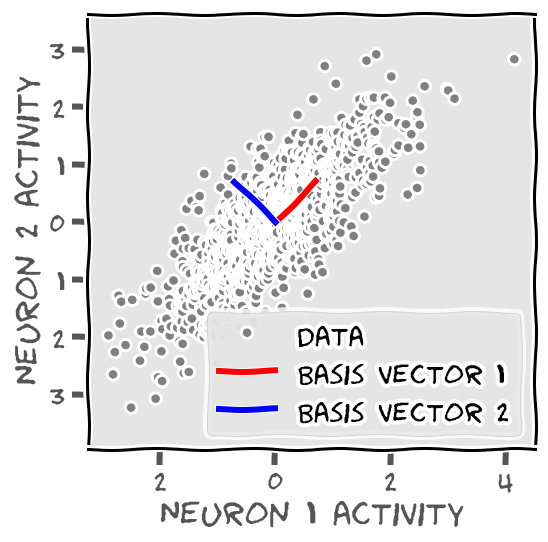

In [10]:
# to_remove solution

evals, evectors = np.linalg.eig(cov_matrix)
evals, evectors = sort_evals_descending(evals,evectors)

with plt.xkcd():
  plot_basis_vectors(X,evectors)


# Perform PCA by projecting data onto the eigenvectors.


To perform PCA, we will project the data onto the eigenvectors of the covariance matrix, i.e.:
\begin{equation}
\bf S = X W
\end{equation}
where $\bf S$ is an $N_\text{samples} \times N$ matrix representing the projected data (also called *scores*), and $W$ is an $N\times N$ orthogonal matrix, each of whose columns represents the eigenvectors of the covariance matrix (also called *weights* or *loadings*). 

#### Exercise
We will now perform PCA on the data using the intuition we have built. Fill in the function below to carry out the steps to perform PCA by projecting the data onto the eigenvectors of its covariance matrix.

**Suggestions**
* First subtract the mean.
* Then calculate the covariance.
* Then find the eigenvalues and order them in descending order.
* Finally project the mean-centered data onto the eigenvectors.

In [11]:
help(change_of_basis)
help(plot_data_new_basis)

Help on function change_of_basis in module __main__:

change_of_basis(X, W)
    Projects data onto a new basis.
    
    Args:
      X (numpy array of floats) : Data matrix
                                  each column corresponding to a different random variable
      W (numpy array of floats):  new orthonormal basis
                                  columns correspond to basis vectors
    
    Returns: 
      (numpy array of floats) : Data matrix expressed in new basis

Help on function plot_data_new_basis in module __main__:

plot_data_new_basis(Y)
    Plots bivariate data after transformation to new bases. Similar to plot_data but
    with colors corresponding to projections onto basis 1 (red) and basis 2 (blue).
    The title indicates the sample correlation calculated from the data.
    
    Note that samples are re-sorted in ascending order for the first random variable.
    
    Args:
      Y (numpy array of floats):   Data matrix in new basis
                                  

In [12]:
def pca(X):
  """
  Sorts eigenvalues and eigenvectors in decreasing order.
  
  Args:
     X (numpy array of floats):   Data matrix 
                                  each column corresponds to a different random variable 
     
  Returns: 
    (numpy array of floats) : Data projected onto the new basis
    (numpy array of floats) : Vector of eigenvalues
    (numpy array of floats) : Corresponding matrix of eigenvectors 
    
  """
  ###################################################################
  ## Insert your code here to ...
  ##                Subtract the mean of X
  ##                Calculate the sample covariance matrix 
  ##                Calculate the eigenvalues and eigenvectors
  ##                Sort the eigenvalues in descending order
  ##                Project the data onto the new eigenvector basis
  ################################################################### 
  return score, evectors, evals

###################################################################
## Insert your code here to:
##                perform PCA on the data matrix X
##                Plot the data projected into the new basis
################################################################### 

# score, evectors, evals = ...
# plot_data_new_basis(score)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


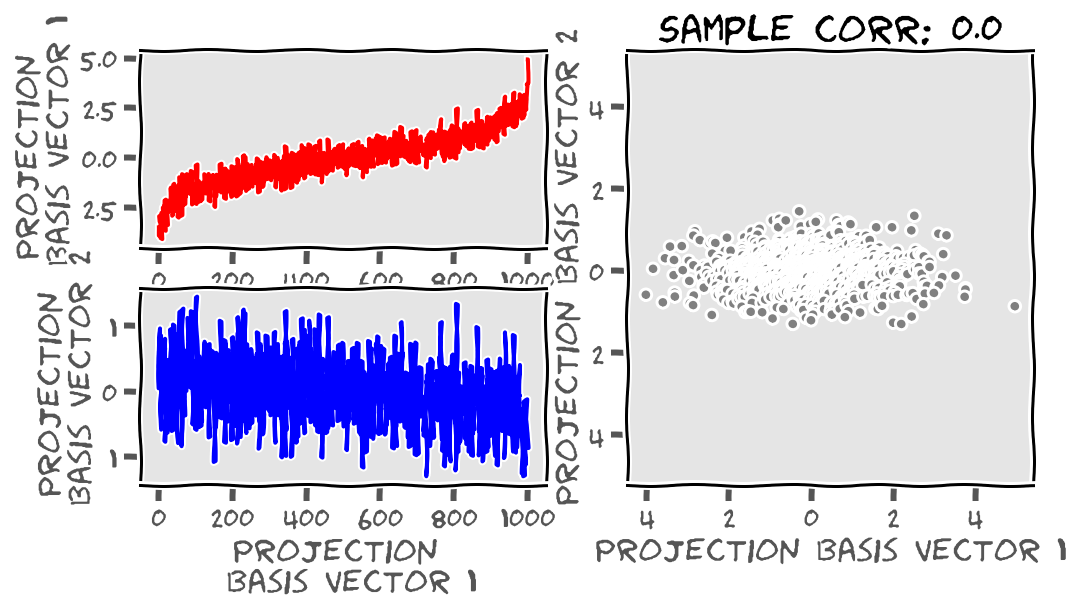

In [13]:
# to_remove solution

def pca(X):
  """
  Performs PCA on multivariate data.
  
  Args:
     X (numpy array of floats):   Data matrix 
                                  each column corresponds to a different random variable 
     
  Returns: 
    (numpy array of floats) : Data projected onto the new basis
    (numpy array of floats) : Vector of eigenvalues
    (numpy array of floats) : Corresponding matrix of eigenvectors 
    
  """
  X = X - np.mean(X,0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eig(cov_matrix)
  evals, evectors = sort_evals_descending(evals,evectors)
  score = change_of_basis(X,evectors)
  return score, evectors, evals

with plt.xkcd():
  score, evectors, evals = pca(X)
  plot_data_new_basis(score)

# Plot and explore the eigenvalues.



Video available at https://youtube.com/watch?v=uPcrB8B9S7A


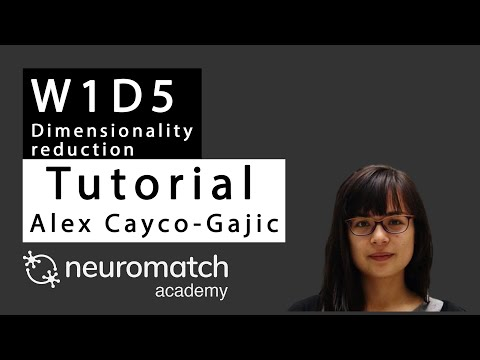

In [14]:
#@title Video: Properties of PCA
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="uPcrB8B9S7A", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


   
Finally, we will examine the eigenvalues of the covariance matrix, which represent the variance of the projected data. Run the code below to plot the eigenvalues (sometimes called the "scree plot"). Which eigenvalue is larger?

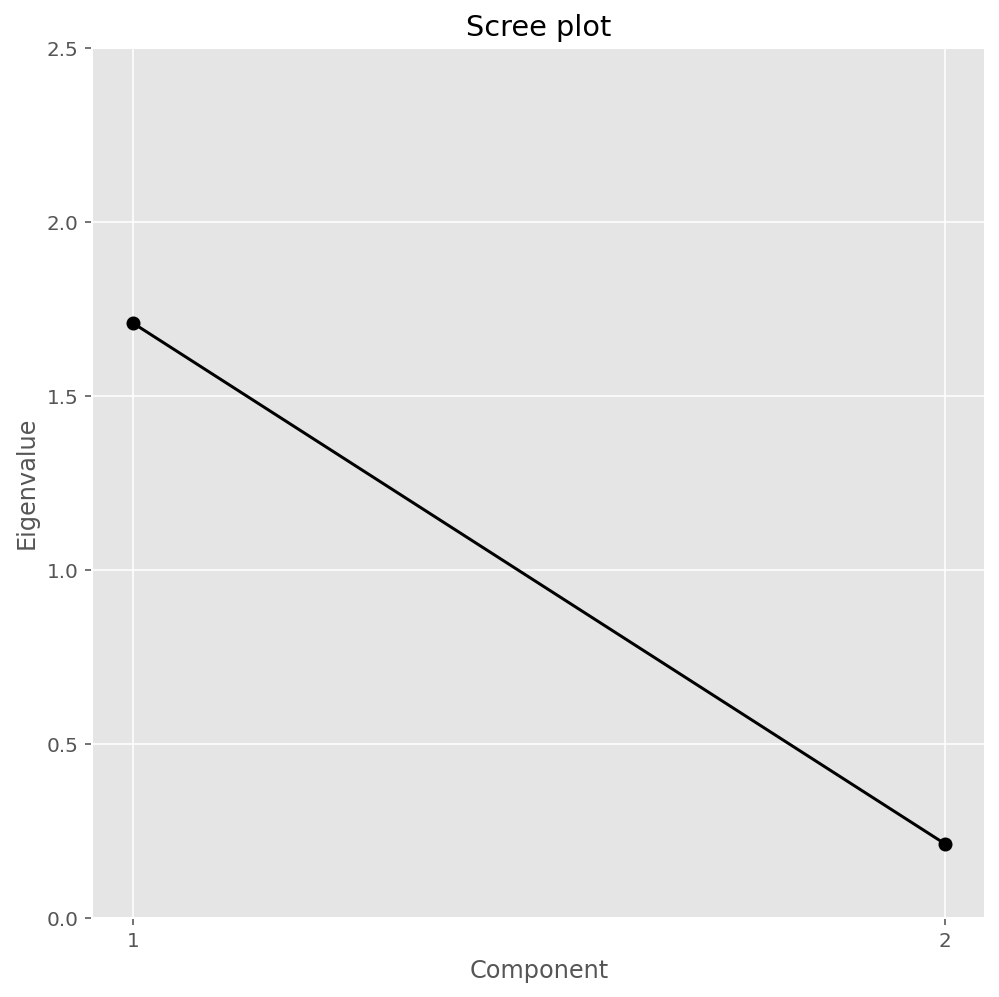

In [15]:
 plot_eigenvalues(evals)

Now, run the following cell and use the slider to change the correlation coefficient in the data. You should see the scree plot and the plot of basis vectors update.

**Questions:**
* What happens to the eigenvalues as you change the correlation coefficient?
* Can you find a value when both eigenvalues are equal?
* Can you find a value when only one eigenvalue is nonzero?

In [16]:
###### MAKE SURE TO RUN THIS CELL VIA THE PLAY BUTTON TO ENABLE SLIDERS ########

import ipywidgets as widgets

def refresh(corr_coef = .8):
  cov_matrix = calculate_cov_matrix(variance_1,variance_2,corr_coef)
  X = get_data(cov_matrix)
  score, evectors, evals = pca(X)
  plot_eigenvalues(evals)
  plot_basis_vectors(X,evectors)

_ = widgets.interact(refresh, 
  corr_coef = (-1, 1, .1))


interactive(children=(FloatSlider(value=0.8, description='corr_coef', max=1.0, min=-1.0), Output()), _dom_clas…